# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from matplotlib.gridspec import GridSpec

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neural_network import MLPClassifier

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/ĐATN/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/ĐATN/Dataset/healthcare-dataset-stroke-data.csv


In [2]:
data = pd.read_csv("/content/drive/MyDrive/ĐATN/Dataset/healthcare-dataset-stroke-data.csv")
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **Exploratory Data Analysis**

In [3]:
# Checking the Data
def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.50, 0.75, 0.90, 0.95, 0.99]).T)


# Grab Column Names
def grab_col_names(dataframe, cat_th=10, car_th=20):

# cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


# Outliers Threshold
def outlier_th(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_th(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False  

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_th(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit    
    

# Missing Values
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
    
# Fill missing values by KNN 
def knn_fill(dataframe,feature):
    from sklearn.impute import KNNImputer
    from sklearn.preprocessing import StandardScaler    # V
    scaler = StandardScaler()                           # V
    imputer = KNNImputer(n_neighbors=5)
    dataframe1 = pd.get_dummies(dataframe[[feature]], drop_first=True)
    dataframe1 = pd.DataFrame(scaler.fit_transform(dataframe1), columns=dataframe1.columns)
    dataframe1 = pd.DataFrame(imputer.fit_transform(dataframe1), columns=dataframe1.columns)
    dataframe1 = pd.DataFrame(scaler.inverse_transform(dataframe1), columns=dataframe1.columns)
    dataframe[feature] = dataframe1[feature]

In [4]:
check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
--------------------     Data Shape     --------------------
(5110, 12)

------------------

In [5]:
"""
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.      #cardinal : chủ yếu, cốt yếu
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold value for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                Categorical view cardinal variable list
"""
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 5110
Variables: 12
cat_cols: 8
num_cols: 4
cat_but_car: 0
num_but_cat: 3


In [6]:
for col in num_cols:
    print(col, check_outlier(df, col)) # Kiem tra ngoai le

id False
age False
avg_glucose_level False
bmi True


In [7]:
for col in num_cols:
    replace_with_thresholds(df, col) # Thay the bang cac nguong

In [8]:
for col in num_cols:
    print(col, check_outlier(df, col))

id False
age False
avg_glucose_level False
bmi False


In [9]:
missing_values_table(df)

     n_miss  ratio
bmi     201   3.93


In [10]:
knn_fill(df,"bmi")

# **Data Visualization**

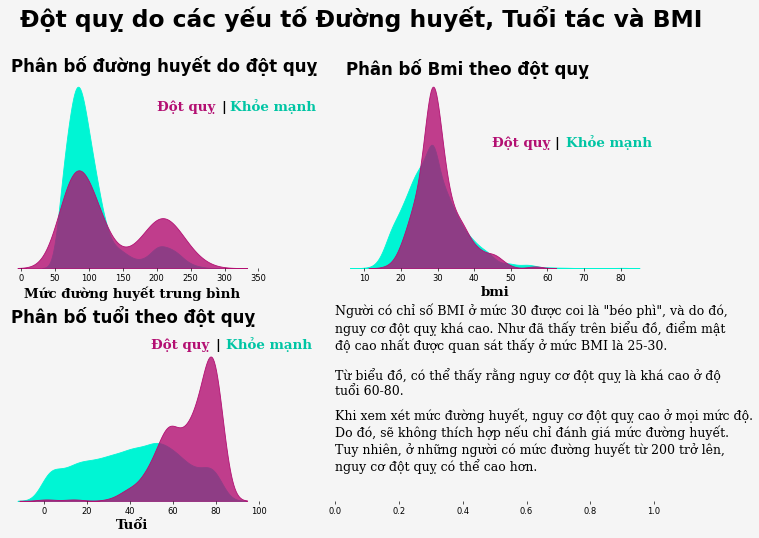

In [11]:
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['#00f5d4','#f15bb5']))

ax1 = fig.add_subplot(gs[1:6, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[1:6, 5:])
ax4 = fig.add_subplot(gs[8:, 5:])

# axes list
axes = [ ax1,ax2, ax3, ax4]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x='avg_glucose_level', data=df[df.stroke==0], ax=ax1, shade=True, color='#00f5d4', alpha=1)
sns.kdeplot(x='avg_glucose_level', data=df[df.stroke==1], ax=ax1, shade=True, color='#b30f72', alpha=0.8)
ax1.set_xlabel('Mức đường huyết trung bình', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax1.text(-15, 0.0175, 'Phân bố đường huyết do đột quỵ', {'size':'20','color': 'black','weight':'bold'})

ax1.text(200, 0.014,'Đột quỵ', {'font':'Serif', 'fontsize':16, 'fontweight':'bold', 'color':'#b30f72'})
ax1.text(295, 0.014,'|', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax1.text(308, 0.014,'Khỏe mạnh', {'font':'Serif', 'fontsize':16, 'fontweight':'bold', 'color':'#00c5a4'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='age', data=df[df.stroke==0], ax=ax2, shade=True, 
            color='#00f5d4', alpha=1)
sns.kdeplot(x='age', data=df[df.stroke==1], ax=ax2, shade=True, 
            color='#b30f72', alpha=0.8)
ax2.set_xlabel('Tuổi', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax2.text(-15, 0.049, 'Phân bố tuổi theo đột quỵ', {'size':'20','color': 'black','weight':'bold'})

ax2.text(50, 0.042,'Đột quỵ', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'#b30f72'})
ax2.text(80, 0.042,'|', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax2.text(85, 0.042,'Khỏe mạnh', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'#00c5a4'})

#-------Ax 3------------------------------------------------
sns.kdeplot(x='bmi', data=df[df.stroke==0], ax=ax3, shade=True, 
            color='#00f5d4', alpha=1)
sns.kdeplot(x='bmi', data=df[df.stroke==1], ax=ax3, shade=True, 
            color='#b30f72', alpha=0.8)
ax3.set_xlabel('bmi', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.text(5, 0.099, 'Phân bố Bmi theo đột quỵ', {'size':'20','color': 'black','weight':'bold'})

ax3.text(45, 0.062,'Đột quỵ', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'#b30f72'})
ax3.text(62, 0.062,'|', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.text(65, 0.062,'Khỏe mạnh', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'#00c5a4'})


ax4.text(0, 0.999, 'Người có chỉ số BMI ở mức 30 được coi là "béo phì"' +\
         ', và do đó,\nnguy cơ đột quỵ khá cao. ' +\
         'Như đã thấy trên biểu đồ, điểm mật\nđộ cao nhất được quan sát thấy ở mức BMI là 25-30.', 
         {'font':'Serif', 'color': 'black', 'size':15})
ax4.text(0, 0.699, 'Từ biểu đồ, có thể thấy rằng nguy cơ đột quỵ là khá cao ở độ' +\
         '\ntuổi 60-80.', 
         {'font':'Serif', 'color': 'black', 'size':15})
ax4.text(0, 0.199, 'Khi xem xét mức đường huyết, nguy cơ đột quỵ cao ở mọi mức độ.' +\
         '\nDo đó, sẽ không thích hợp nếu chỉ đánh giá mức đường huyết.'
         '\nTuy nhiên, ở những người có mức đường huyết từ 200 trở lên, \nnguy cơ đột quỵ có thể cao hơn.', 
         {'font':'Serif', 'color': 'black', 'size':15})
#---------------------------------------------------------------
fig.text(0.06, 0.9, 'Đột quỵ do các yếu tố Đường huyết, Tuổi tác và BMI', {'weight':'bold','color': 'black', 'size':28})
plt.show()

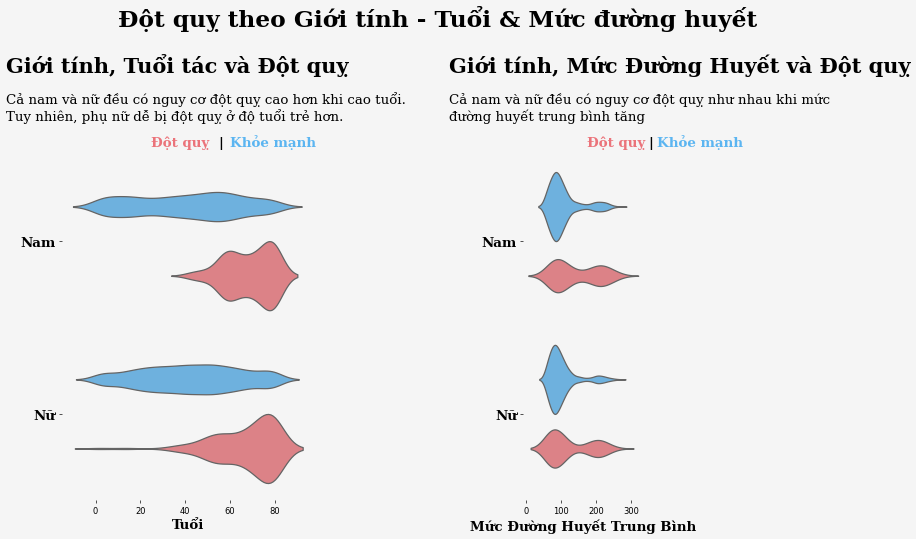

In [12]:
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['#5bb5f1','#eb737a']))

ax1 = fig.add_subplot(gs[3:, 1:5])

ax3 = fig.add_subplot(gs[3:, 8:])

# axes list
axes = [ ax1,ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
ax1.get_yaxis().set_visible(True)
sns.violinplot(x='age', y='gender', data=df[df.gender!='Other'],
               hue='stroke', ax=ax1, aspect=2, inner=None)
ax1.set_yticklabels( labels = ['Nam', 'Nữ'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax1.set_ylabel('')
ax1.set_xlabel('Tuổi', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax1.get_legend().remove()
ax1.text(-40, -0.975, 'Giới tính, Tuổi tác và Đột quỵ', {'font':'Serif', 'size':'25','color': 'black','weight':'bold'})
ax1.text(-40, -0.7, 'Cả nam và nữ đều có nguy cơ đột quỵ cao hơn khi cao tuổi.' +\
         '\nTuy nhiên, phụ nữ dễ bị đột quỵ ở độ tuổi trẻ hơn.', 
         {'font':'Serif', 'color': 'black', 'size':16})
ax1.text(25,-0.55,'Đột quỵ', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'#eb737a'})
ax1.text(55,-0.55,'|', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax1.text(60,-0.55,'Khỏe mạnh', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'#5bb5f1'})



#-------Ax 3------------------------------------------------
ax3.get_yaxis().set_visible(True)
sns.violinplot(x='avg_glucose_level', y='gender', data=df[df.gender!='Other'],
               hue='stroke', ax=ax3, aspect=2, inner=None)
ax3.set_yticklabels( labels = ['Nam', 'Nữ'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_ylabel('')
ax3.set_xlabel('Mức Đường Huyết Trung Bình', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.get_legend().remove()
ax3.text(-220, -0.975, 'Giới tính, Mức Đường Huyết và Đột quỵ', {'font':'Serif', 'size':'25','color': 'black','weight':'bold'})
ax3.text(-220, -0.7, 'Cả nam và nữ đều có nguy cơ đột quỵ như nhau khi mức\nđường huyết trung bình tăng', 
         {'font':'Serif', 'color': 'black', 'size':16})
ax3.text(175,-0.55,'Đột quỵ', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'#eb737a'})
ax3.text(350,-0.55,'|', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.text(375,-0.55,'Khỏe mạnh', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'#5bb5f1'})

#---------------------------------------------------------------
fig.text(0.135, 0.9, 'Đột quỵ theo Giới tính - Tuổi & Mức đường huyết', {'font':'Serif', 'weight':'bold','color': 'black', 'size':28})
plt.show()

In [13]:
import plotly.express as px

fig = px.histogram(df,
                   x='work_type',
                   barmode='group',
                   color='stroke',
                   text_auto=True,
                   labels={
                       'work_type': 'Loại công việc',
                       'stroke': 'Đột quỵ',
                       'count': 'No. of People'
                   },
                   template='plotly_dark')

fig.update_layout(yaxis_title="Số Lượng Người")

fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor='right', x=0.99))

fig.update_layout(font_color='lavender',
                  legend_title_font_color="deeppink",
                  yaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  xaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  legend_font_size=15)

# Changing the label names in the legend -
newnames = {'0': 'Không', '1': 'Có'}
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(
                                          t.name, newnames[t.name])))

fig.show()

In [14]:
fig = px.histogram(df,
                   x='ever_married',
                   barmode='group',
                   color='stroke',
                   text_auto=True,
                   labels={'stroke': 'Đột quỵ',
                           'ever_married': 'Tình trạng hôn nhân'},
                   template='plotly_dark',
                   )

fig.update_layout(yaxis_title="Số Lượng Người")

fig.update_layout(legend=dict(
    yanchor="top", y=0.95, xanchor='right', x=0.18, bgcolor='black'))

fig.update_layout(font_color='lavender',
                  legend_title_font_color="magenta",
                  yaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  xaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  legend_font_size=12)

newnames = {'0': 'Không', '1': 'Có'}
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(
                                          t.name, newnames[t.name])))

fig.show()

In [15]:
fig = px.histogram(df,
                   x='heart_disease',
                   color='stroke',
                   barmode='group',
                   labels={'stroke': 'Đột quỵ',
                           'heart_disease': 'Bệnh Tim'},
                   text_auto=True,
                   template='plotly_dark')

fig.update_layout(yaxis_title="Số lượng người")
fig.update_layout(legend=dict(
    yanchor="top", y=0.99, xanchor='right', x=0.99, bgcolor='black'))

newnames = {'0': 'Không', '1': 'Có'}
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(
                                          t.name, newnames[t.name])))

fig.update_layout(font_color='lavender',
                  legend_title_font_color="magenta",
                  yaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  xaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  legend_font_size=12)

fig.show()

In [16]:
fig = px.histogram(df,
                   x='hypertension',
                   color='stroke',
                   barmode='group',
                   labels={'stroke': 'Đột quỵ',
                           'hypertension': 'Tăng Huyết Áp'},
                   text_auto=True,
                   template='plotly_dark')

fig.update_layout(yaxis_title="Số Lượng Người")
fig.update_layout(legend=dict(
    yanchor="top", y=0.97, xanchor='right', x=0.92, bgcolor='black'))

newnames = {'0': 'Không', '1': 'Có'}
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(
                                          t.name, newnames[t.name])))

fig.update_layout(font_color='lavender',
                  legend_title_font_color="magenta",
                  yaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  xaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  legend_font_size=15)

fig.show()

# **New Features**

In [17]:
df['bmi_cat'] = pd.cut(df['bmi'], bins = [0,19,25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['age_cat'] = pd.cut(df['age'], bins = [0,13,18,45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df['glucose_cat'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

# **Encoding - Scaling**

In [18]:
le = LabelEncoder()

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [19]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [20]:
for col in binary_cols:
    df = label_encoder(df, col)
    
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)

In [21]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Male,...,bmi_cat_Ideal,bmi_cat_Overweight,bmi_cat_Obesity,age_cat_Teens,age_cat_Adults,age_cat_Mid Adults,age_cat_Elderly,glucose_cat_Normal,glucose_cat_High,glucose_cat_Very High
0,-1.298312,1.051434,0,1,1,1,2.706375,1.007449,1,1,...,0,0,1,0,0,0,1,0,1,0
1,0.716371,0.786070,0,0,1,0,2.121559,0.000000,1,0,...,0,1,0,0,0,0,1,0,1,0
2,-0.255478,1.626390,0,1,1,0,-0.005028,0.471878,1,1,...,0,0,1,0,0,0,1,1,0,0
3,1.118363,0.255342,0,0,1,1,1.437358,0.720070,1,0,...,0,0,1,0,0,1,0,0,1,0
4,-1.647136,1.582163,1,0,1,0,1.501184,-0.638451,1,0,...,1,0,0,0,0,0,1,0,1,0


# **Modeling**

In [22]:
y = df["stroke"]
X = df.drop(["stroke","id"], axis=1)

In [23]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
x_smote,y_smote=smote.fit_resample(X,y)

X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.33,random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.35, random_state=42)

sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# **Logistic Regression**

In [24]:
LR=LogisticRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       563
           1       0.80      0.85      0.83       561

    accuracy                           0.82      1124
   macro avg       0.82      0.82      0.82      1124
weighted avg       0.82      0.82      0.82      1124



In [25]:
auc = roc_auc_score(y_test, y_pred)
auc

0.8221173177813027

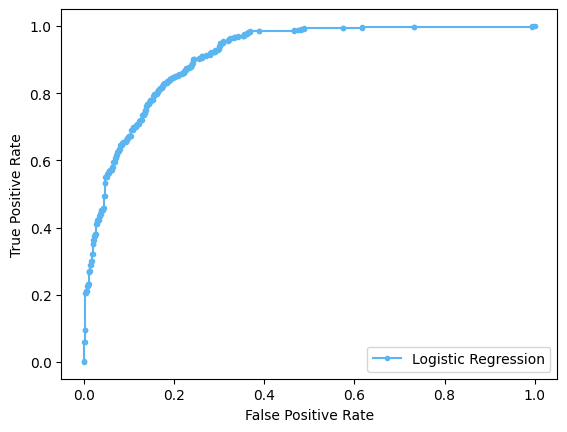

In [26]:
cm = confusion_matrix(y_test, y_pred)
predicted_probab_log = LR.predict_proba(X_test)
predicted_probab_log = predicted_probab_log[:, 1]
fpr, tpr, _ = roc_curve(y_test, predicted_probab_log)

from matplotlib import pyplot
pyplot.plot(fpr, tpr, marker='.', label='Logistic Regression')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

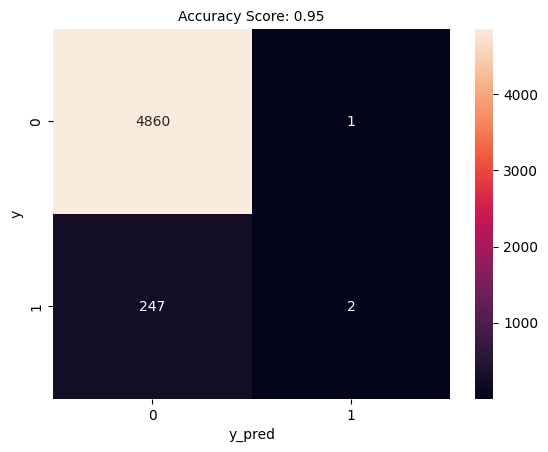

In [27]:
log_model = LogisticRegression().fit(X, y)
y_pred = log_model.predict(X)

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show(block=True)

plot_confusion_matrix(y, y_pred)

In [28]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.67      0.01      0.02       249

    accuracy                           0.95      5110
   macro avg       0.81      0.50      0.50      5110
weighted avg       0.94      0.95      0.93      5110



In [29]:
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8537618897726268

# **Hold-Out**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

smote_over_sampling = SMOTE(random_state=1)
x_train_resampled, y_train_resampled = smote_over_sampling.fit_resample(X_train, y_train)

log_model = LogisticRegression().fit(x_train_resampled, y_train_resampled)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       972
           1       0.11      0.38      0.17        50

    accuracy                           0.81      1022
   macro avg       0.54      0.61      0.53      1022
weighted avg       0.92      0.81      0.86      1022



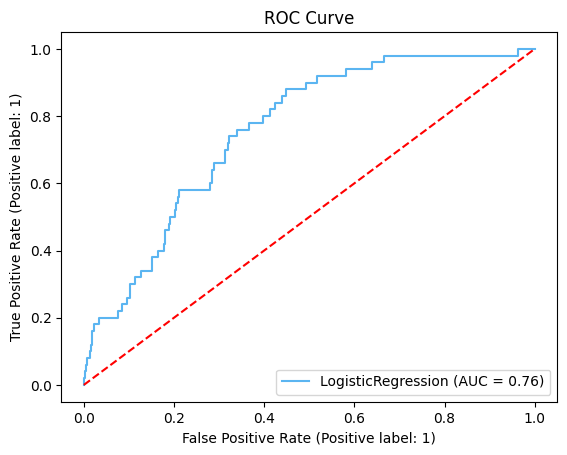

0.7571604938271606

In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
RocCurveDisplay.from_estimator(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()
roc_auc_score(y_test, y_prob)

# **5-Fold Cross Validation**

In [32]:
from sklearn.model_selection import train_test_split, cross_validate
log_model = LogisticRegression().fit(x_train_resampled, y_train_resampled)

cv_results = cross_validate(log_model,
                            x_train_resampled, y_train_resampled,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("test_accuracy: ", cv_results['test_accuracy'].mean())
print("test_f1: ", cv_results['test_f1'].mean())
print("test_roc_auc: ", cv_results['test_roc_auc'].mean())

test_accuracy:  0.8579347655378207
test_f1:  0.8610980544546376
test_roc_auc:  0.9319190488684477


# **KNeighborsClassifier**

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier().fit(X, y)
y_pred = knn_model.predict(X)
y_prob = knn_model.predict_proba(X)[:, 1]
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4861
           1       0.54      0.09      0.15       249

    accuracy                           0.95      5110
   macro avg       0.75      0.54      0.56      5110
weighted avg       0.93      0.95      0.94      5110



In [34]:
### Cross Validation
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("test_accuracy: ", cv_results['test_accuracy'].mean())
print("test_f1: ", cv_results['test_f1'].mean())
print("test_roc_auc: ", cv_results['test_roc_auc'].mean())

test_accuracy:  0.9465753424657535
test_f1:  0.013676212741087084
test_roc_auc:  0.6330757321364591


In [35]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [36]:
knn_params = {"n_neighbors": range(2, 50)}
knn_gs_best = GridSearchCV(knn_model, knn_params, cv=5, n_jobs=-1, verbose=1).fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [37]:
knn_params = {"n_neighbors": range(2, 50)}
knn_gs_best.best_params_

{'n_neighbors': 12}

In [38]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)

print("test_accuracy: ", cv_results['test_accuracy'].mean())
print("test_f1: ", cv_results['test_f1'].mean())
print("test_roc_auc: ", cv_results['test_roc_auc'].mean())

test_accuracy:  0.9465753424657535
test_f1:  0.013676212741087084
test_roc_auc:  0.6330757321364591


# **Model Evaluation using 4-Classification Models**

In [39]:
results = pd.DataFrame(columns = ['KNN', 'SVC', 'LR', 'RF'], index = range(5))

**KNN**

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       972
           1       0.14      0.50      0.22        50

    accuracy                           0.82      1022
   macro avg       0.56      0.67      0.56      1022
weighted avg       0.93      0.82      0.87      1022

ROC AUC score: 0.725

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.957
precision: 0.85
recall: 0.99
f1: 0.91


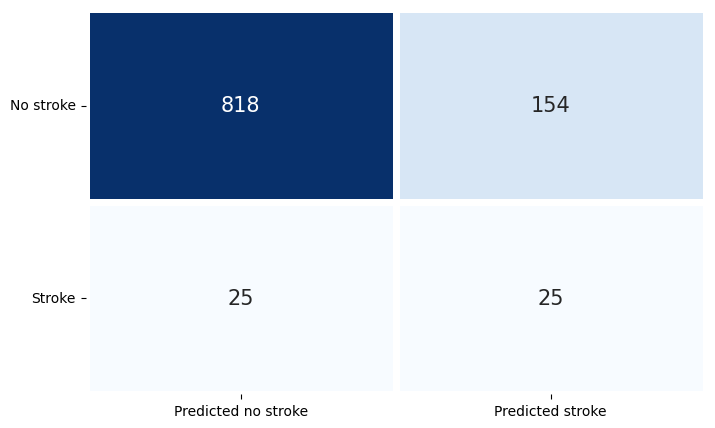

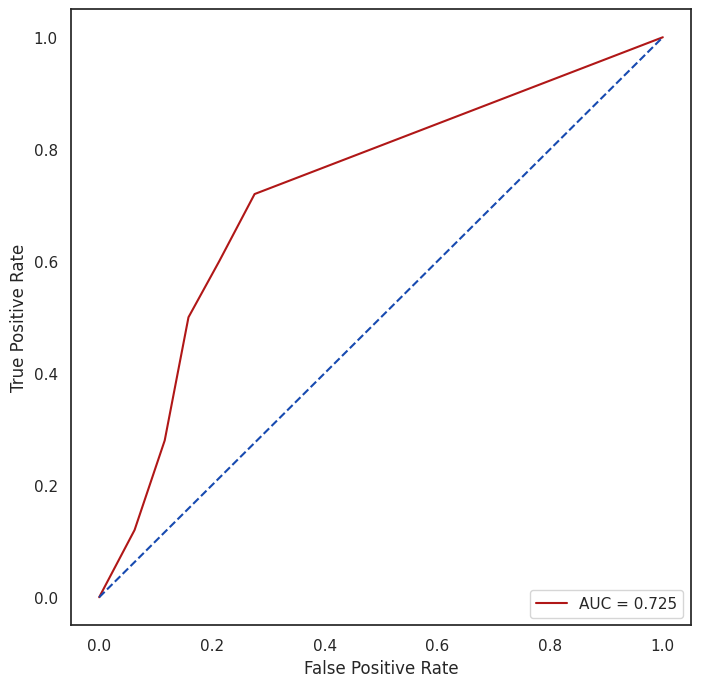

In [40]:
knn = KNeighborsClassifier()
knn.fit(x_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 1] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 1] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 1] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 1] = round(roc_auc_score(y_test, y_prob), 3)
knn_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 1] = round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(knn_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
knn_false_positive_rate, knn_true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

knn_roc_auc = metrics.auc(knn_false_positive_rate, knn_true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(knn_false_positive_rate,knn_true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % knn_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**SVC**

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       972
           1       0.12      0.40      0.19        50

    accuracy                           0.83      1022
   macro avg       0.54      0.62      0.54      1022
weighted avg       0.92      0.83      0.87      1022

ROC AUC score: 0.776

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.966
precision: 0.87
recall: 0.96
f1: 0.91


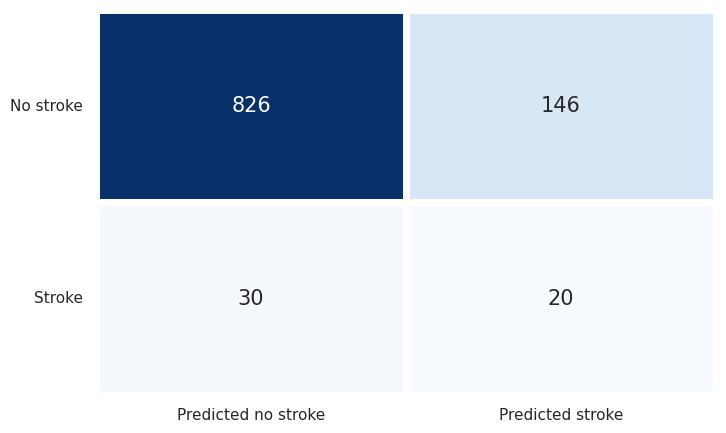

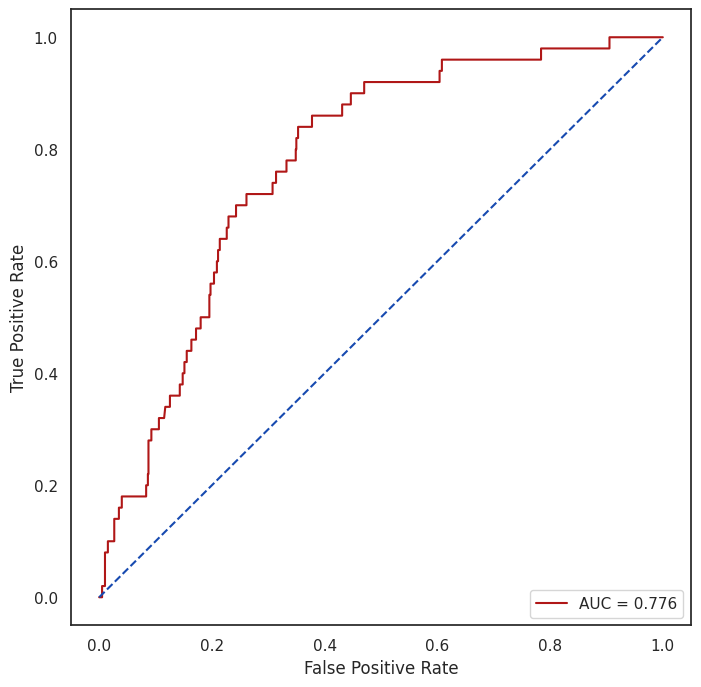

In [41]:
svc = SVC(random_state = 22, probability = True)
svc.fit(x_train_resampled, y_train_resampled)
y_pred = svc.predict(X_test)
y_prob = svc.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 0] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 0] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 0] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 0] = round(roc_auc_score(y_test, y_prob), 3)
svc_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")


results.iloc[4, 0] = round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)


# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(svc_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
svc_false_positive_rate, svc_true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

svc_roc_auc = metrics.auc(svc_false_positive_rate, svc_true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(svc_false_positive_rate,svc_true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % svc_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Random Forest Classifier**

              precision    recall  f1-score   support

           0       0.98      0.70      0.82       972
           1       0.12      0.78      0.21        50

    accuracy                           0.71      1022
   macro avg       0.55      0.74      0.51      1022
weighted avg       0.94      0.71      0.79      1022

ROC AUC score: 0.816

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.913
precision: 0.76
recall: 0.93
f1: 0.84


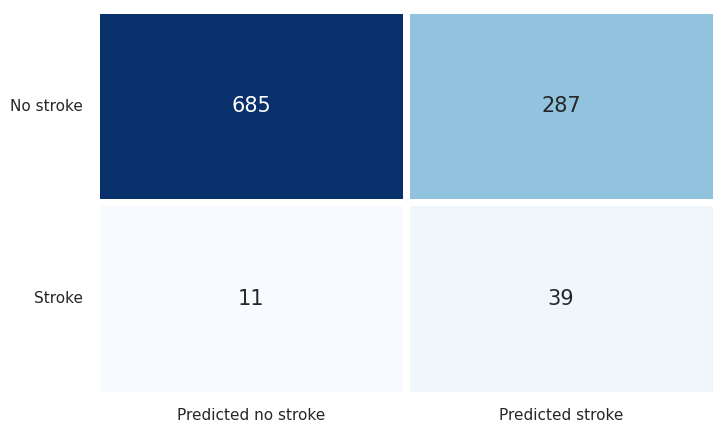

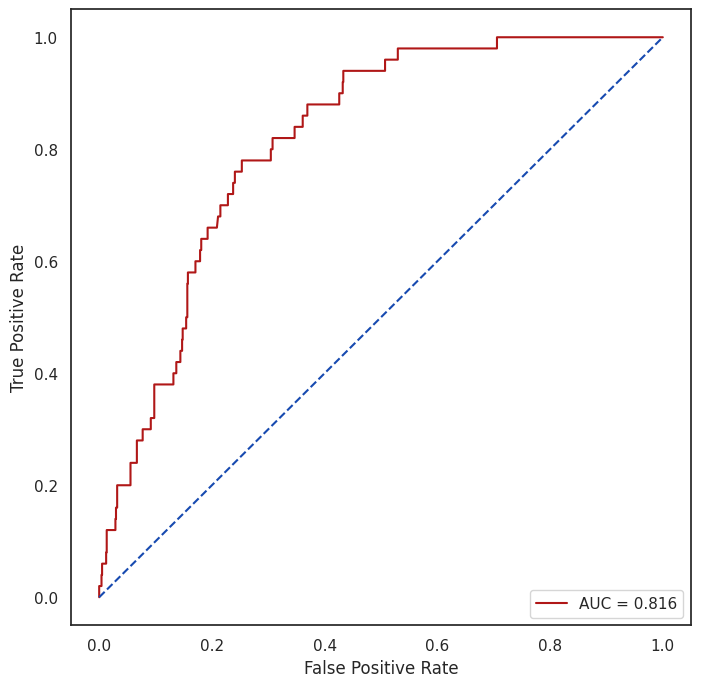

,feature,importance
0,age,0.359329
22,age_cat_Elderly,0.158697
20,age_cat_Adults,0.156906
5,avg_glucose_level,0.054093
12,work_type_children,0.053264
6,bmi,0.052521
3,ever_married,0.025995
21,age_cat_Mid Adults,0.024655
14,smoking_status_never smoked,0.018338
19,age_cat_Teens,0.013509


In [42]:
rf = RandomForestClassifier(random_state = 42, max_depth = 5)
rf.fit(x_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 3] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 3] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 3] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 3] = round(roc_auc_score(y_test, y_prob), 3)
rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 3] = round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)


# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
rf_false_positive_rate, rf_true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics
rf_roc_auc = metrics.auc(rf_false_positive_rate, rf_true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(rf_false_positive_rate,rf_true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % rf_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp2 = pd.DataFrame(columns = ['feature', 'importance'], index = range(26))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i, 0] = x_train_resampled.columns.to_list()[i]
f_imp2['importance'] = rf.feature_importances_
f_imp2 = f_imp2.sort_values('importance', ascending = False)
f_imp2[0:12].style.background_gradient(cmap = 'Blues')

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       972
           1       0.11      0.38      0.17        50

    accuracy                           0.81      1022
   macro avg       0.54      0.61      0.53      1022
weighted avg       0.92      0.81      0.86      1022

ROC AUC score: 0.757

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.932
precision: 0.84
recall: 0.89
f1: 0.86


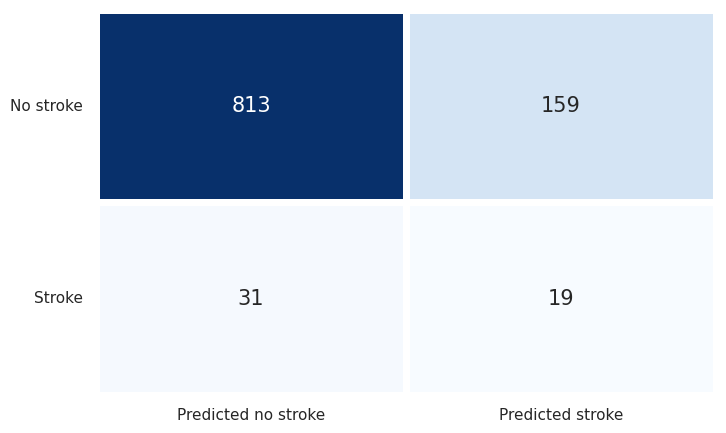

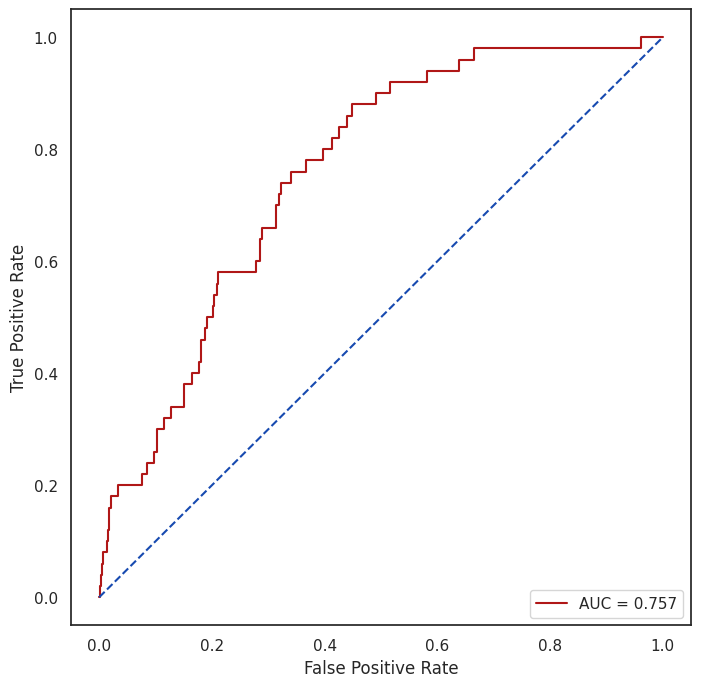

,feature,importance (abs coef)
12,work_type_children,4.564707
22,age_cat_Elderly,4.278142
20,age_cat_Adults,3.764389
21,age_cat_Mid Adults,3.429033
0,age,3.125425
16,bmi_cat_Ideal,2.962755
18,bmi_cat_Obesity,2.898508
19,age_cat_Teens,2.871259
25,glucose_cat_Very High,2.397447
14,smoking_status_never smoked,2.033017


In [43]:
lg = LogisticRegression(random_state = 42)
lg.fit(x_train_resampled, y_train_resampled)
y_pred = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 2] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 2] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 2] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 2] = round(roc_auc_score(y_test, y_prob), 3)
lg_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 2] = round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(lg_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
lg_false_positive_rate, lg_true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

lg_roc_auc = metrics.auc(lg_false_positive_rate, lg_true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(lg_false_positive_rate,lg_true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % lg_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp = pd.DataFrame(columns = ['feature', 'importance (abs coef)'], index = range(26))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = x_train_resampled.columns.to_list()[i]
f_imp['importance (abs coef)'] = abs(lg.coef_)[0]
f_imp = f_imp.sort_values('importance (abs coef)', ascending = False)
f_imp[0:12].style.background_gradient(cmap = 'Blues')

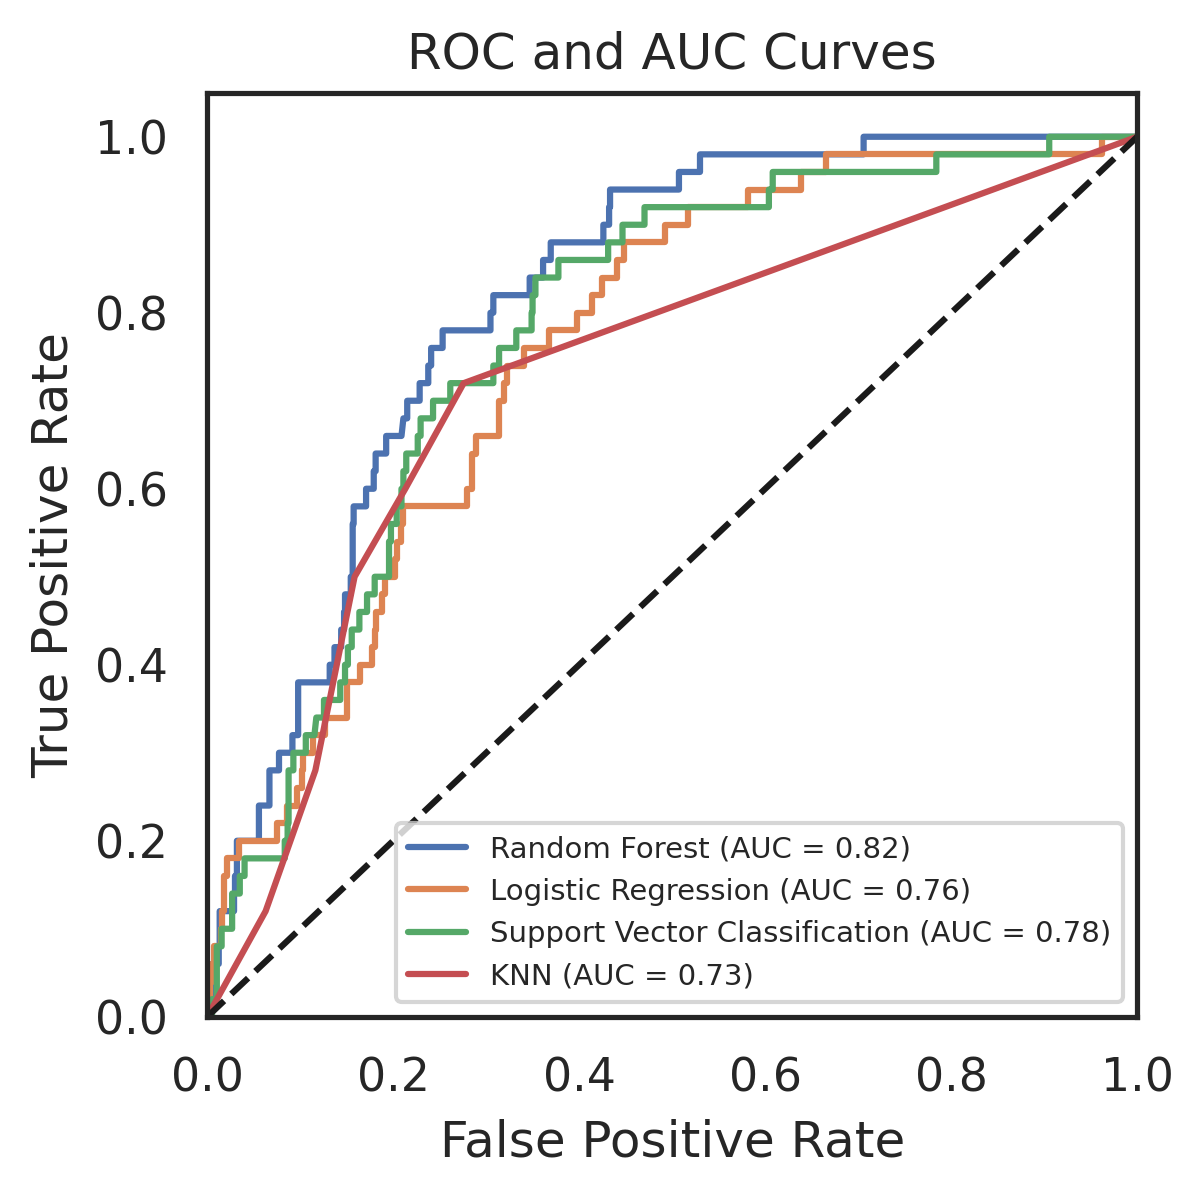

In [44]:
plt.figure(figsize=(4,4),dpi=300)
plt.plot(rf_false_positive_rate, rf_true_positive_rate, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(lg_false_positive_rate, lg_true_positive_rate, label='Logistic Regression (AUC = %0.2f)' % lg_roc_auc)
plt.plot(svc_false_positive_rate, svc_true_positive_rate, label='Support Vector Classification (AUC = %0.2f)' % svc_roc_auc)
plt.plot(knn_false_positive_rate, knn_true_positive_rate, label='KNN (AUC = %0.2f)' % knn_roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC Curves')
plt.legend(loc="lower right",fontsize=7)
plt.show()

# **Viet**

In [45]:
rf.predict(X)

array([1, 1, 1, ..., 0, 0, 0])

In [46]:
import joblib
# save
joblib.dump(rf, "./random_forest.joblib")

# save with compression to save memory
#joblib.dump(rf, "RF_compressed.joblib", compress=3)

['./random_forest.joblib']

In [47]:
from google.colab import files
files.download("./random_forest.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
# load, no need to initialize the loaded_rf
loaded_rf = joblib.load("./random_forest.joblib")

In [49]:
loaded_rf.predict(X)

array([1, 1, 1, ..., 0, 0, 0])

In [50]:
X.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'gender_Male',
       'gender_Other', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'bmi_cat_Ideal', 'bmi_cat_Overweight',
       'bmi_cat_Obesity', 'age_cat_Teens', 'age_cat_Adults',
       'age_cat_Mid Adults', 'age_cat_Elderly', 'glucose_cat_Normal',
       'glucose_cat_High', 'glucose_cat_Very High'],
      dtype='object')

In [51]:
X.head(2)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Male,gender_Other,work_type_Never_worked,...,bmi_cat_Ideal,bmi_cat_Overweight,bmi_cat_Obesity,age_cat_Teens,age_cat_Adults,age_cat_Mid Adults,age_cat_Elderly,glucose_cat_Normal,glucose_cat_High,glucose_cat_Very High
0,1.051434,0,1,1,1,2.706375,1.007449,1,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0.786070,0,0,1,0,2.121559,0.000000,0,0,0,...,0,1,0,0,0,0,1,0,1,0


In [52]:
x = np.zeros(len(X.columns))
x[0]  = 45        # age
x[1]  = 1         # hypertension
x[2]  = 1         # heart_disease
x[3]  = 1         # ever_married
x[4]  = 1         # Residence_type
x[5]  = 200       # avg_glucose_level
x[6]  = 32        # bmi
x[7]  = 0         # gender_Male
x[8]  = 0         # gender_Other
x[9]  = 0         # work_type_Never_worked
x[10] = 0         # work_type_Private
x[11] = 1         # work_type_Self-employed
x[12] = 0         # work_type_children
x[13] = 0         # smoking_status_formerly smoked
x[14] = 1         # smoking_status_never smoked
x[15] = 0         # smoking_status_smokes
x[16] = 0         # bmi_cat_Ideal
x[17] = 0         # bmi_cat_Overweight
x[18] = 1         # bmi_cat_Obesity
x[19] = 0         # age_cat_Teens
x[20] = 0         # age_cat_Adults
x[21] = 1         # age_cat_Mid Adults
x[22] = 0         # age_cat_Elderly
x[23] = 0         # glucose_cat_Normal
x[24] = 1         # glucose_cat_High
x[25] = 0         # glucose_cat_Very High

result = loaded_rf.predict([x])[0]
#print(result)

#percent = loaded_rf.predict_proba([x])[:,1]
#print("Bạn có nguy cơ mắc đột quỵ cao hơn người bình thường", round(percent[0]*100,2),"%")

# Kha nang mac dot quy: [1,0] = [co nguy co, khong co nguy co]
if result == 0:
    print("Khong co nguy co bi dot quy")
else:
    print("Co nguy co bi dot quy")
    result_proba = loaded_rf.predict_proba([x])[:,1]
    print("Bạn có nguy cơ mắc đột quỵ cao hơn người bình thường", round(result_proba[0]*100,2),"%")

Co nguy co bi dot quy
Bạn có nguy cơ mắc đột quỵ cao hơn người bình thường 51.58 %
